<a href="https://colab.research.google.com/github/HenryJi529/ColabNotebooks/blob/main/PracticePytorch4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [ ]:
# Check for GPU
!nvidia-smi

Sun Apr  9 08:57:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    32W /  70W |   3667MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install torchmetrics
!pip install -U mlxtend
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import requests
import zipfile
from pathlib import Path
import os
from typing import Tuple, Dict, List
import time
import datetime 
from tqdm.auto import tqdm

import random
from PIL import Image

import torchvision
from torchvision import transforms, datasets

import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'
# plt.rcParams['figure.dpi'] = 400

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import mlxtend
from mlxtend.plotting import plot_confusion_matrix

import torchmetrics
from torchmetrics import ConfusionMatrix, Accuracy

from torchinfo import summary

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

- 增加模型复杂度【增加模型的层数/节点数，更换激活函数】: 提高模型的复杂度，从而提高模型的拟合能力。
- 训练更多epoch
- 调节学习速率
- 修改代价函数
- 增加特征数量: 通过增加特征数量，提高模型的表达能力，从而提高模型的拟合能力。
- 减少正则化: 在损失函数中减少正则化项，从而提高模型的拟合能力。
- 迁移学习

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [ ]:
# 1. Get data
data_dir = Path("data")
image_dir = data_dir / "pizza_steak_sushi"
download_path = data_dir / "pizza_steak_sushi.zip"
if image_dir.is_dir():
  print(f"{image_dir} already exists")
else:
  image_dir.mkdir(parents=True, exist_ok=True)
  with open(download_path, "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(request.content)

  with zipfile.ZipFile(download_path, "r") as zip_ref:
    zip_ref.extractall(image_dir)

data/pizza_steak_sushi already exists


In [ ]:
# 2. Become one with the data
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  image_num = 0
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    image_num += len(filenames)
  print(f"总的数量为: {image_num}")
walk_through_dir(image_dir)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
总的数量为: 300


In [ ]:
# Setup train and testing paths
train_dir = image_dir / "train"
test_dir = image_dir / "test"

Random image path: data/pizza_steak_sushi/train/steak/3245622.jpg
Image class: steak
Image height: 262
Image width: 512


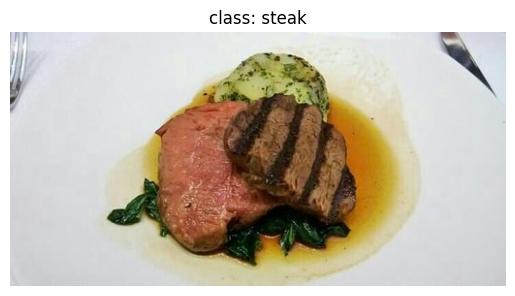

In [ ]:
# Visualize an image
image_path_list = list(image_dir.glob("*/*/*.jpg"))
image_path_random = random.choice(image_path_list)
image_class = image_path_random.parent.stem
image_random = torchvision.io.read_image(str(image_path_random))
plt.imshow(image_random.permute(1,2,0))
plt.title(f"class: {image_class}")
plt.axis("off")

print(f"Random image path: {image_path_random}")
print(f"Image class: {image_class}")
print(f"Image height: {image_random.shape[1]}")
print(f"Image width: {image_random.shape[2]}")

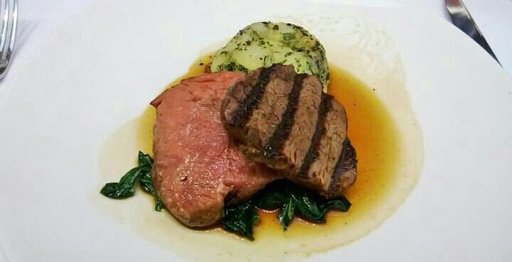

In [ ]:
# Do the image visualization with pillow
image = Image.open(image_path_random)
image

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [ ]:
# 3.1 Transforming data with torchvision.transforms
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
data_transform(image).shape

torch.Size([3, 64, 64])

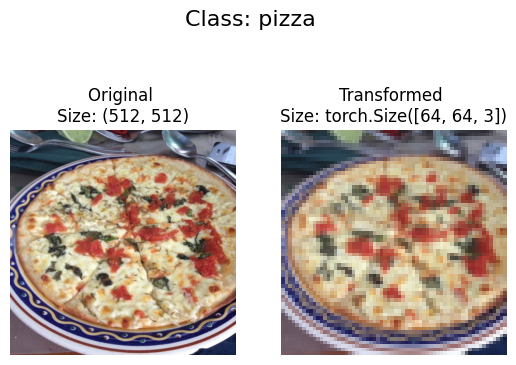

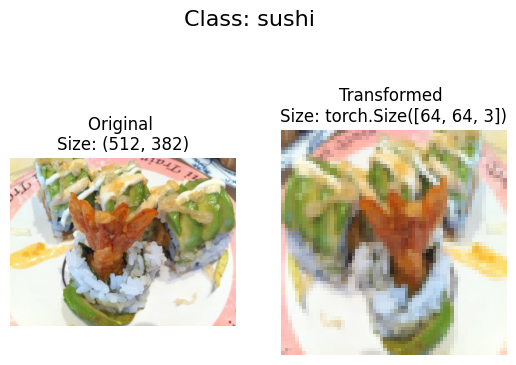

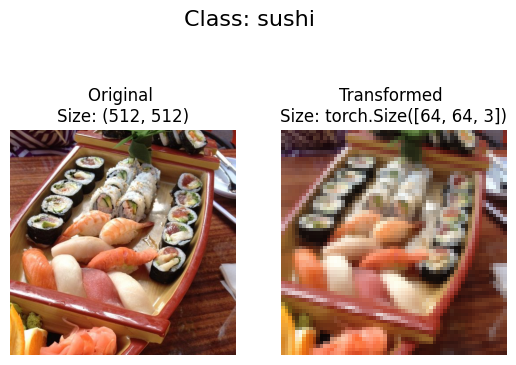

In [ ]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths: list, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2,)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3, seed=54)

### Load image data using `ImageFolder`

In [ ]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform,
                                  target_transform=None)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [ ]:
print(train_data.targets[:3])
print(train_data.imgs[:3])

[0, 0, 0]
[('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0), ('data/pizza_steak_sushi/train/pizza/1033251.jpg', 0), ('data/pizza_steak_sushi/train/pizza/1044789.jpg', 0)]


In [ ]:
# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=os.cpu_count())

In [ ]:
# How many batches of images are in our data loaders?
train_dataloader.__len__()

8

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape

torch.Size([32, 3, 64, 64])

In [ ]:
input_channels = train_features_batch.shape[1]
rows = train_features_batch.shape[2]
cols = train_features_batch.shape[3]

class TinyVGG(torch.nn.Module):
  """
  Model copying from CNN Explainer
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,stride=1,padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,stride=1,padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,stride=1,padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,stride=1,padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*int(rows*cols/4/4),
                  out_features=output_shape)
    )

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    # Z1 = self.conv_block_1(x)
    # Z2 = self.conv_block_2(Z1)
    # Z3 = self.classifier(Z2)
    # return Z3
    return self.classifier(self.conv_block_2(self.conv_block_1(x))) # operator fusion

model = TinyVGG(input_channels, 16, len(train_data.classes)).to(DEVICE)
summary(model, input_size=train_features_batch.shape)

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 16, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 16, 64, 64]          448
│    └─ReLU: 2-2                         [32, 16, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 16, 64, 64]          2,320
│    └─ReLU: 2-4                         [32, 16, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 16, 32, 32]          --
├─Sequential: 1-2                        [32, 16, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 16, 32, 32]          2,320
│    └─ReLU: 2-7                         [32, 16, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 16, 32, 32]          2,320
│    └─ReLU: 2-9                         [32, 16, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 16, 16, 16]          --
├─Seq

## 4. Create training and testing functions for `model_0`.

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch in dataloader:
    # Send data to target device
    X, y = batch
    X, y = X.to(DEVICE), y.to(DEVICE)
    # 1. Forward pass
    y_pred_logits = model(X)   
    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred_logits, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()
    

    # Calculate and accumualte accuracy metric across all batches
    train_acc += (y_pred_logits.argmax(dim=1)==y).sum().item()/len(y_pred_logits)


  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch in dataloader:
      # Send data to target device
      X, y = batch
      X, y = X.to(DEVICE), y.to(DEVICE)

      # 1. Forward pass
      y_pred_logits = model(X)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(y_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_acc += (y_pred_logits.argmax(dim=1)==y).sum().item()/len(y_pred_logits)

    
  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [ ]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=0.001)

start_time = time.time()

results = train(model, train_dataloader, test_dataloader, optimizer, loss_fn, 100 )

end_time = time.time()
during_time = int(end_time - start_time)
print(f"运行时间: {datetime.timedelta(seconds=during_time)}")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1053 | train_acc: 0.2539 | test_loss: 1.1064 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0746 | train_acc: 0.4258 | test_loss: 1.1375 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0747 | train_acc: 0.4258 | test_loss: 1.1536 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.0620 | train_acc: 0.4727 | test_loss: 1.1228 | test_acc: 0.2812
Epoch: 5 | train_loss: 0.9945 | train_acc: 0.5703 | test_loss: 1.0549 | test_acc: 0.3210
Epoch: 6 | train_loss: 0.9292 | train_acc: 0.6172 | test_loss: 1.2667 | test_acc: 0.4025
Epoch: 7 | train_loss: 0.9251 | train_acc: 0.5508 | test_loss: 1.1614 | test_acc: 0.3636
Epoch: 8 | train_loss: 0.9570 | train_acc: 0.4570 | test_loss: 0.9950 | test_acc: 0.4545
Epoch: 9 | train_loss: 0.9773 | train_acc: 0.5078 | test_loss: 1.0827 | test_acc: 0.3617
Epoch: 10 | train_loss: 0.8781 | train_acc: 0.5234 | test_loss: 0.9919 | test_acc: 0.4839
Epoch: 11 | train_loss: 0.8234 | train_acc: 0.6797 | test_loss: 0.9934 | test_acc: 0.4432
Epoch: 12 | train_l

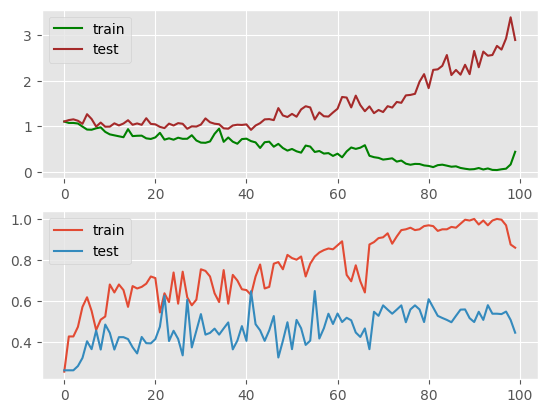

In [ ]:
with plt.style.context('ggplot'):
  fig, axes = plt.subplots(2,1)
  epochs = len(results['train_loss'])
  axes[0].plot(range(epochs), results["train_loss"], label="train", color="green")
  axes[0].plot(range(epochs), results["test_loss"], label="test", color="brown")
  axes[0].legend()
  axes[1].plot(range(epochs), results["train_acc"], label="train")
  axes[1].plot(range(epochs), results["test_acc"], label="test")
  axes[1].legend()

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1094 | train_acc: 0.4102 | test_loss: 1.1171 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1227 | train_acc: 0.3047 | test_loss: 1.1139 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0962 | train_acc: 0.4453 | test_loss: 1.1201 | test_acc: 0.2917
Epoch: 4 | train_loss: 1.0831 | train_acc: 0.4258 | test_loss: 1.1441 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.1185 | train_acc: 0.3047 | test_loss: 1.1140 | test_acc: 0.2917
Epoch: 6 | train_loss: 1.0838 | train_acc: 0.5039 | test_loss: 1.0810 | test_acc: 0.5152
Epoch: 7 | train_loss: 1.0668 | train_acc: 0.4102 | test_loss: 1.0488 | test_acc: 0.4328
Epoch: 8 | train_loss: 0.9879 | train_acc: 0.4688 | test_loss: 0.9563 | test_acc: 0.5445
Epoch: 9 | train_loss: 0.8790 | train_acc: 0.6406 | test_loss: 1.0878 | test_acc: 0.4242
Epoch: 10 | train_loss: 0.8528 | train_acc: 0.6445 | test_loss: 1.1413 | test_acc: 0.3930
Epoch: 11 | train_loss: 0.9128 | train_acc: 0.5547 | test_loss: 1.1192 | test_acc: 0.3920
Epoch: 12 | train_l

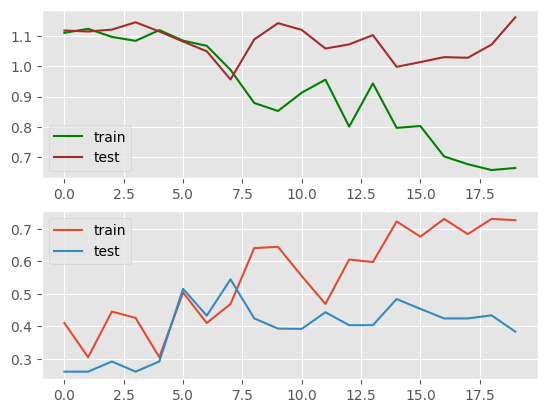

In [ ]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model = TinyVGG(input_channels, 32, len(train_data.classes)).to(DEVICE)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=0.001)

start_time = time.time()

results = train(model, train_dataloader, test_dataloader, optimizer, loss_fn, 20 )

end_time = time.time()
during_time = int(end_time - start_time)
print(f"运行时间: {datetime.timedelta(seconds=during_time)}")

with plt.style.context('ggplot'):
  fig, axes = plt.subplots(2,1)
  epochs = len(results['train_loss'])
  axes[0].plot(range(epochs), results["train_loss"], label="train", color="green")
  axes[0].plot(range(epochs), results["test_loss"], label="test", color="brown")
  axes[0].legend()
  axes[1].plot(range(epochs), results["train_acc"], label="train")
  axes[1].plot(range(epochs), results["test_acc"], label="test")
  axes[1].legend()

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [ ]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

data/pizza_steak_sushi_20_percent directory exists.
Unzipping pizza, steak, sushi 20% data...


In [ ]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
总的数量为: 600


Excellent, we now have double the training and testing images... 

In [ ]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [ ]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

train_transform = transforms.Compose([
    transforms.Resize((160,160)),
    transforms.TrivialAugmentWide(5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((160,160)),
    transforms.ToTensor()
])

# Create datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                  transform=test_transform,
                                  target_transform=None)

# Create dataloaders
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=os.cpu_count())

In [ ]:
test_data

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1724 | train_acc: 0.4023 | test_loss: 1.4858 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.1652 | train_acc: 0.4180 | test_loss: 1.0252 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.1367 | train_acc: 0.4141 | test_loss: 1.0491 | test_acc: 0.5227
Epoch: 4 | train_loss: 1.1207 | train_acc: 0.2812 | test_loss: 1.1295 | test_acc: 0.2282
Epoch: 5 | train_loss: 1.1132 | train_acc: 0.2656 | test_loss: 1.1721 | test_acc: 0.1875
Epoch: 6 | train_loss: 1.1208 | train_acc: 0.3008 | test_loss: 1.1183 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1116 | train_acc: 0.3164 | test_loss: 1.0568 | test_acc: 0.5417
Epoch: 8 | train_loss: 1.1105 | train_acc: 0.2812 | test_loss: 1.0969 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.0926 | train_acc: 0.3594 | test_loss: 1.1155 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.1084 | train_acc: 0.3047 | test_loss: 1.1262 | test_acc: 0.2604
Epoch: 11 | train_loss: 1.1009 | train_acc: 0.3047 | test_loss: 1.1058 | test_acc: 0.2604
Epoch: 12 | train_l

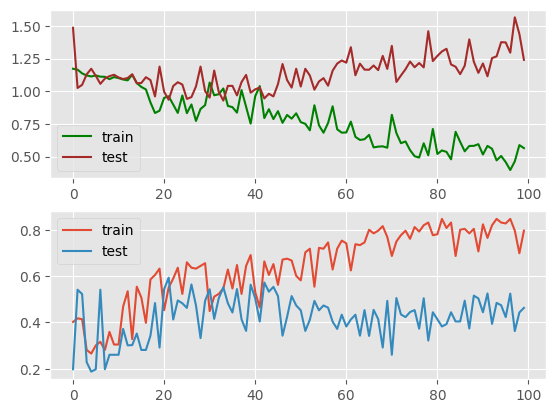

In [ ]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape
input_channels = train_features_batch.shape[1]
rows = train_features_batch.shape[2]
cols = train_features_batch.shape[3]

model = TinyVGG(input_channels, 16, len(train_data.classes)).to(DEVICE)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=0.001, weight_decay=0.001)

start_time = time.time()

results = train(model, train_dataloader, test_dataloader, optimizer, loss_fn, 100)

end_time = time.time()
during_time = int(end_time - start_time)
print(f"运行时间: {datetime.timedelta(seconds=during_time)}")

with plt.style.context('ggplot'):
  fig, axes = plt.subplots(2,1)
  epochs = len(results['train_loss'])
  axes[0].plot(range(epochs), results["train_loss"], label="train", color="green")
  axes[0].plot(range(epochs), results["test_loss"], label="test", color="brown")
  axes[0].legend()
  axes[1].plot(range(epochs), results["train_acc"], label="train")
  axes[1].plot(range(epochs), results["test_acc"], label="test")
  axes[1].legend()

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?

In [ ]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(DEVICE)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(DEVICE))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

In [ ]:
import requests

custom_image_path = data_dir / "pizza-dad.jpeg"

if custom_image_path.is_file():
  print("already downloaded")
else:
  r = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/04-pizza-dad.jpeg")
  with open(custom_image_path, "wb") as f:
    f.write(r.content)

already downloaded


In [ ]:
custom_image_transform = transforms.Compose([
    transforms.Resize((160, 160)),
])

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


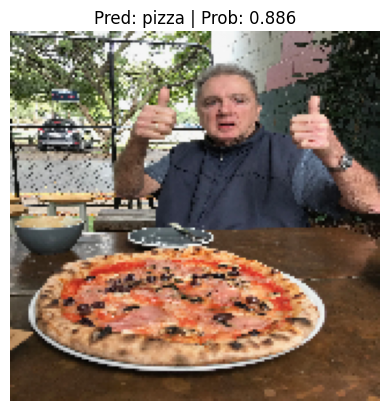

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform)